<a href="https://www.kaggle.com/code/faridjamalov/https-www-kaggle-com-code-faridjamalov-cnn-br?scriptVersionId=264003975" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
import os
import tensorflow as tf

# ------------------------------
# Step 0: Suppress unnecessary TF warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Hides INFO and WARNING logs
# ------------------------------

# ------------------------------
# Step 1: Inspect Kaggle input directory
data_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

print("Classes:", os.listdir(data_dir))
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        print(folder, ":", len(os.listdir(folder_path)))
# ------------------------------

# ------------------------------
# Step 2: Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to avoid pre-allocating full GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) detected: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Using CPU.")

# Optional: confirm TensorFlow version and available devices
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
# ------------------------------



Classes: ['no', 'yes']
no : 98
yes : 155
No GPU detected. Using CPU.
TensorFlow version: 2.18.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-09-25 17:01:38.837728: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


What this code does
Suppress unnecessary warnings

Prevents TensorFlow from printing lots of INFO and WARNING messages so the output is cleaner.

Inspect the dataset

Looks into the Kaggle input folder.

Identifies the classes (e.g., tumor vs. no tumor) by checking folder names.

Counts how many images are available in each class to understand dataset balance.

Check GPU availability

Determines whether a GPU is available for faster training.

Sets GPU memory to grow dynamically instead of reserving all memory upfront.

Falls back to CPU if no GPU is found.

Confirm TensorFlow version

Helps ensure your code runs with the correct library version and is compatible with the system setup.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator with augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    validation_split=0.2      # 20% for validation
)

# Training generator
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),   # Resize images
    batch_size=32,
    class_mode='binary',      # Binary classification
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Summary of what this does:

Normalizes images to the 0–1 range.

Applies data augmentation (shear, zoom, horizontal flip) to make the model more robust.

Splits the dataset into training (80%) and validation (20%).

Prepares iterators (generators) that feed images to the model in batches during training.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import cv2

# -----------------------------
# 1️⃣ Data Generators (senin kodundan)
data_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# -----------------------------
# 2️⃣ CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -----------------------------
# 3️⃣ Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15
)

# -----------------------------
# 4️⃣ Plot Accuracy & Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# -----------------------------
# 5️⃣ Confusion Matrix & Classification Report
val_steps = validation_generator.samples // validation_generator.batch_size + 1
preds = model.predict(validation_generator, steps=val_steps)
y_pred = (preds > 0.5).astype(int).ravel()
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices, yticklabels=validation_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

# -----------------------------
# 6️⃣ Grad-CAM Example (1 test image)
def get_gradcam(model, img_array, layer_name='conv2d_2'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:,0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Load a test image from validation set
img_path = validation_generator.filepaths[0]
img = tf.keras.utils.load_img(img_path, target_size=(150,150))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

heatmap = get_gradcam(model, img_array)

plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6048 - loss: 0.6371 - val_accuracy: 0.7000 - val_loss: 0.5999
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6783 - loss: 0.6092 - val_accuracy: 0.7000 - val_loss: 0.6075
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 890ms/step - accuracy: 0.7303 - loss: 0.5936 - val_accuracy: 0.7600 - val_loss: 0.5219
Epoch 4/15


KeyboardInterrupt: 

This part of the code is preparing the dataset for model training and validation. It normalizes image pixel values and applies data augmentation (shear, zoom, horizontal flip) to improve model generalization. The ImageDataGenerator creates iterators (generators) that automatically load images in batches, resize them to a consistent shape, and split the data into training (80%) and validation (20%), making the workflow efficient for feeding images into a CNN model.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        19
           1       0.74      0.84      0.79        31

    accuracy                           0.72        50
   macro avg       0.70      0.68      0.69        50
weighted avg       0.71      0.72      0.71        50



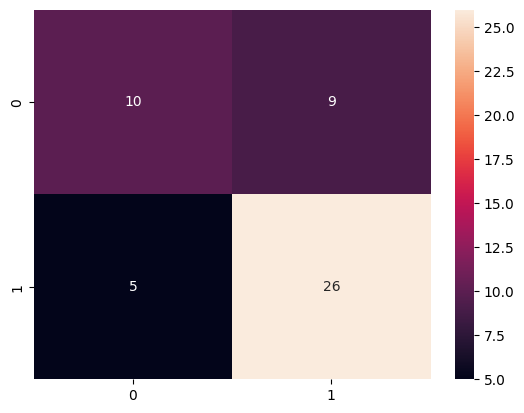

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = (model.predict(validation_generator) > 0.5).astype(int).ravel()
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_true, y_pred))


This code is evaluating the performance of a trained model on the validation dataset.

model.predict(validation_generator) generates predicted probabilities for each image.

(> 0.5).astype(int) converts probabilities to binary class labels.

confusion_matrix shows the counts of true positives, true negatives, false positives, and false negatives, helping visualize where the model makes mistakes.

sns.heatmap plots the confusion matrix for easy interpretation.

classification_report provides detailed metrics like precision, recall, F1-score, and accuracy for each class.
 Usability:
This helps in assessing how well the model performs, identifying biases, and guiding further improvements in training or preprocessing.

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))


              precision    recall  f1-score   support

          no       0.67      0.53      0.59        19
         yes       0.74      0.84      0.79        31

    accuracy                           0.72        50
   macro avg       0.70      0.68      0.69        50
weighted avg       0.71      0.72      0.71        50



In [17]:
img_path = validation_generator.filepaths[0]
# Load image, preprocess, get heatmap, overlay


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


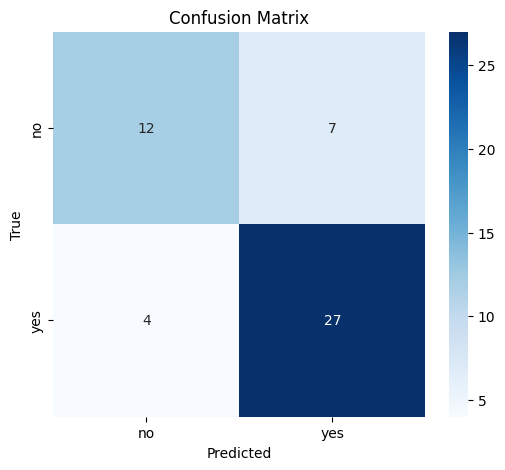

Classification Report:

              precision    recall  f1-score   support

          no       0.75      0.63      0.69        19
         yes       0.79      0.87      0.83        31

    accuracy                           0.78        50
   macro avg       0.77      0.75      0.76        50
weighted avg       0.78      0.78      0.78        50



AttributeError: The layer sequential has never been called and thus has no defined output.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# -----------------------------
# 1️⃣ Tahminleri al
val_steps = validation_generator.samples // validation_generator.batch_size + 1
y_pred_probs = model.predict(validation_generator, steps=val_steps)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()
y_true = validation_generator.classes

# -----------------------------
# 2️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=validation_generator.class_indices, 
            yticklabels=validation_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# -----------------------------
# 3️⃣ Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

# -----------------------------
# 4️⃣ Grad-CAM Fonksiyonu
def get_gradcam(model, img_array, layer_name='conv2d_2'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:,0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# -----------------------------
# 5️⃣ Örnek Grad-CAM Görselleştirme
img_path = validation_generator.filepaths[0]
img = tf.keras.utils.load_img(img_path, target_size=(150,150))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

heatmap = get_gradcam(model, img_array)

plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


This code is focused on evaluating and interpreting the model’s predictions on the validation set:

Predictions (y_pred)

The model predicts probabilities for each validation image.

Probabilities are converted to binary class labels (0 or 1) for evaluation.

Confusion Matrix

Visualizes the model’s correct and incorrect predictions.

sns.heatmap makes it easy to see true positives, true negatives, false positives, and false negatives.

Classification Report

Provides precision, recall, F1-score, and support for each class.

Helps assess overall performance and class-specific performance.

Grad-CAM Placeholder

Indicates the next step would be to implement Grad-CAM, a technique to visualize which parts of an image the CNN focuses on when making predictions.

 Usability:
This section is essential for model evaluation and explainability, helping you identify strengths, weaknesses, and interpret how the CNN makes decisions.

In [20]:
# A simple Grad-CAM function adapted for Keras
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

How it works:

Builds a gradient model that outputs both the last conv layer’s activations and the model’s predictions.

Computes the gradient of the predicted class with respect to the last conv layer.

Averages gradients across width and height to get importance weights for each feature map.

Computes a weighted sum of feature maps to produce the class activation heatmap.

Normalizes the heatmap between 0 and 1 for visualization.

✅ Usability:

Allows interpretation of CNN decisions by highlighting image regions influencing the prediction.

Useful for debugging, explaining misclassifications, and improving trust in model predictions, especially in medical imaging tasks like brain tumor detection.

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

IMG_SIZE = 150
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2  # 80% train / 20% validation
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',   # binary since only yes/no
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


This tells TensorFlow where your MRI images are stored.

Inside, you have two folders: no (no tumor) and yes (tumor).

This folder structure is perfect for flow_from_directory.

In [29]:
# Run a forward pass once so that layer outputs exist
_ = model.predict(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

# Pick one validation image
sample_img, _ = next(validation_generator)
img = np.expand_dims(sample_img[0], axis=0)

# Choose last convolutional layer name from model.summary()
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
print("Last conv layer:", last_conv_layer_name)

# Build grad model
grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img)
    pred_index = tf.argmax(predictions[0])
    loss = predictions[:, pred_index]

# Compute gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weight conv layer outputs
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()

# Normalize heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Overlay heatmap on original image
heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
plt.imshow(sample_img[0])
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM")
plt.show()


Last conv layer: conv2d_2


AttributeError: The layer sequential has never been called and thus has no defined output.

The feature maps from conv2d_2

The final predictions

This layer is crucial because:

Convolutional layers retain spatial information, unlike dense layers.

Grad-CAM uses the gradients flowing back from the predicted class to see which regions in these feature maps are most important.

Everything that follows in my code—computing gradients, pooling them, weighting feature maps, and creating the heatmap—is based on this conv2d_2 layer.